## Regression Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Define Dataset

In [2]:
df = pd.read_csv("housePrice.csv")
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [3]:
cdf = df[["Area", "Room", "Parking", "Warehouse", "Elevator", "Address", "Price(USD)"]] # Price(USD) is the label.
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 119.0+ KB


In [4]:
cdf = cdf.dropna()
cdf.isnull().sum()

Area          0
Room          0
Parking       0
Warehouse     0
Elevator      0
Address       0
Price(USD)    0
dtype: int64

### Preprocessing

In [5]:
# convert the value of "Area" from object to int64 and if its non-convertible the value will be nan.
cdf["Area"] = pd.to_numeric(cdf["Area"], errors="coerce")
cdf = cdf.dropna()

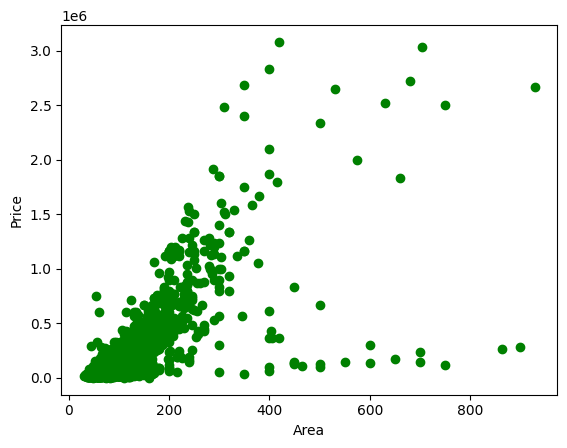

In [6]:
plt.scatter(cdf["Area"], cdf["Price(USD)"], color="green")
plt.xlabel("Area")
plt.ylabel("Price")
plt.show()

In [7]:
# this cell drops outlier datas, I determined that if value of "Area" is more than 300 It is outlier.
Q1 = cdf["Area"].quantile(0.25)
Q3 = cdf["Area"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 4 * IQR

cdf["Area"] = cdf["Area"].where(cdf["Area"] <= upper_bound, np.nan) # value if less than 300 else nan.
cdf = cdf.dropna()

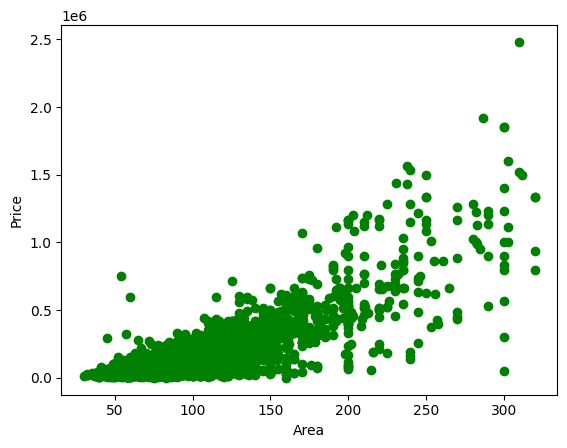

In [8]:
plt.scatter(cdf["Area"], cdf["Price(USD)"], color="green")
plt.xlabel("Area")
plt.ylabel("Price")
plt.show()

In [9]:
# convert boolean values to int64.
cdf["Parking"] = cdf["Parking"].astype(int)
cdf["Warehouse"] = cdf["Warehouse"].astype(int)
cdf["Elevator"] = cdf["Elevator"].astype(int)

cdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3399 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3399 non-null   float64
 1   Room        3399 non-null   int64  
 2   Parking     3399 non-null   int64  
 3   Warehouse   3399 non-null   int64  
 4   Elevator    3399 non-null   int64  
 5   Address     3399 non-null   object 
 6   Price(USD)  3399 non-null   float64
dtypes: float64(2), int64(4), object(1)
memory usage: 212.4+ KB


In [10]:
# achieve classes of "Address" to choose the way of encoding (Lable Encoder, One Hot Encoding or Target Encoding).
address_group = cdf.groupby("Address")
address_group.count()

,Area,Room,Parking,Warehouse,Elevator,Price(USD)
Address,,,,,,
Abazar,22,22,22,22,22,22
Abbasabad,2,2,2,2,2,2
Abuzar,3,3,3,3,3,3
Afsarieh,6,6,6,6,6,6
Ahang,2,2,2,2,2,2
...,...,...,...,...,...,...
Yousef Abad,38,38,38,38,38,38
Zafar,9,9,9,9,9,9
Zaferanieh,25,25,25,25,25,25


In [11]:
# split data to train and test.
msk = np.random.rand(len(cdf)) < 0.8

data_train, data_test = cdf[msk], cdf[~msk]

data_train.shape, data_test.shape

((2757, 7), (642, 7))

In [12]:
# I used target encoding to encode "Address".
data_train = data_train.copy() # because of warning message.
mean_prices = data_train.groupby("Address")["Price(USD)"].mean()
data_train["Address_Encoded"] = data_train["Address"].map(mean_prices)
global_price = data_train["Price(USD)"].mean()

data_train.drop("Address", axis=1, inplace=True) # we dont need "Address" anymore.
data_train.head(0)

,Area,Room,Parking,Warehouse,Elevator,Price(USD),Address_Encoded


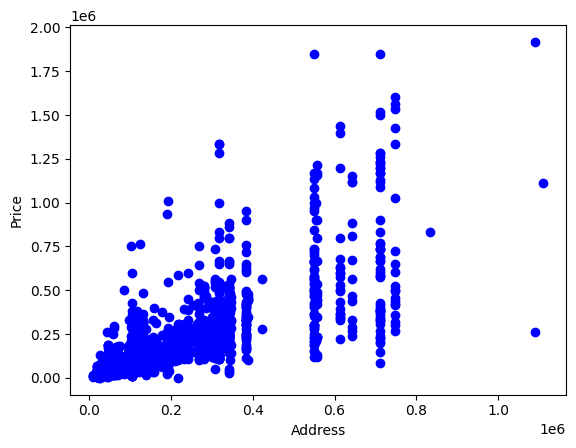

In [13]:
plt.scatter(data_train["Address_Encoded"], data_train["Price(USD)"], color="blue")
plt.xlabel("Address")
plt.ylabel("Price")
plt.show()

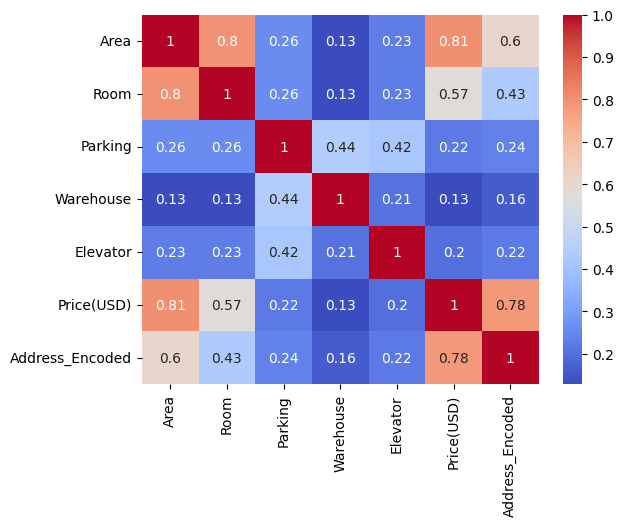

In [14]:
# to see correlation between features and label, it is important to use train data for this process.
corr = data_train.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

In [15]:
# we use features with hight correlations for training.
x_train = np.asanyarray(data_train[["Area", "Room", "Parking", "Address_Encoded"]])
y_train = np.asanyarray(data_train[["Price(USD)"]])

In [16]:
# this cell normalizes train datas.
x_scaler = StandardScaler(copy=False)
y_scaler = StandardScaler(copy=False)
x_scaler.fit_transform(x_train)
y_scaler.fit_transform(y_train)

array([[-0.48598011],
       [-0.48598011],
       [-0.69151315],
       ...,
       [-0.72076205],
       [ 0.10690358],
       [-0.72155258]], shape=(2757, 1))

## Polynomial Regression

### Model Definition

In [17]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train)

x_train[:3], x_train_poly[:3]

(array([[-0.809723  , -1.45184502,  0.42214349, -0.40248661],
        [-0.87390027, -1.45184502,  0.42214349, -0.40248661],
        [-0.46744423, -0.07349216,  0.42214349, -0.84143005]]),
 array([[ 1.        , -0.809723  , -1.45184502,  0.42214349, -0.40248661,
          0.65565134,  1.17559231, -0.34181929,  0.32590266,  2.10785397,
         -0.61288693,  0.58434817,  0.17820513, -0.1699071 ,  0.16199547],
        [ 1.        , -0.87390027, -1.45184502,  0.42214349, -0.40248661,
          0.76370168,  1.26876776, -0.36891131,  0.35173315,  2.10785397,
         -0.61288693,  0.58434817,  0.17820513, -0.1699071 ,  0.16199547],
        [ 1.        , -0.46744423, -0.07349216,  0.42214349, -0.84143005,
          0.21850411,  0.03435348, -0.19732854,  0.39332162,  0.0054011 ,
         -0.03102424,  0.06183851,  0.17820513, -0.35520422,  0.70800453]]))

In [18]:
mymodel = LinearRegression()
mymodel.fit(x_train_poly, y_train)

print(f"coefficient : {mymodel.coef_[0]} | intercept : {mymodel.intercept_[0]}")

coefficient : [ 0.          0.33275942 -0.01225982  0.00795817  0.51144403  0.03769639
  0.00320439  0.01443411  0.27378422  0.01093371  0.00317797 -0.07281192
 -0.01549232  0.02115904 -0.12178121] | intercept : -0.05705250255518286


### Model Evaluation

In [19]:
data_test = data_test.copy() # encode address for test data with the means of train data.
data_test["Address_Encoded"] = data_test["Address"].map(mean_prices)
data_test = data_test.dropna()

data_test.drop("Address", axis=1, inplace=True)
data_test.head(0)

,Area,Room,Parking,Warehouse,Elevator,Price(USD),Address_Encoded


In [20]:
x_test = np.asanyarray(data_test[["Area", "Room", "Parking", "Address_Encoded"]])
y_test = np.asanyarray(data_test[["Price(USD)"]])

In [21]:
x_scaler.transform(x_test) # normalize test data
y_scaler.transform(y_test)

x_test[:3]

array([[-0.65997604, -0.07349216,  0.42214349,  0.17926665],
       [ 1.15837992,  1.30486071,  0.42214349, -0.24683369],
       [-0.16795031, -0.07349216,  0.42214349,  1.32785516]])

In [22]:
x_test_poly = poly.transform(x_test) # transform test data for polynomial model with train metrics.
y_pred = mymodel.predict(x_test_poly)

In [23]:
mse = np.mean((y_test - y_pred) ** 2)
mae = np.mean(np.absolute(y_test - y_pred))
r2 = r2_score(y_test, y_pred)

print(f"mean squared error : {mse} | mean absolute error : {mae} | r2 score : {r2}".title())

Mean Squared Error : 0.22704085703223853 | Mean Absolute Error : 0.20126259443472239 | R2 Score : 0.793198464600178


In [24]:
from tkinter import *
from tkinter import ttk

In [25]:
# I used tkinter to recieve information from user and show the result to user.
def encode_address(address):
    return mean_prices.get(address, global_price)

def predict():
    try:
        area, room, parking, address = float(entry1.get()), int(entry2.get()), combo_box.get(), entry4.get()
        parking = 1 if parking == "Yes" else 0
        address_encoded = encode_address(address)
        x = np.asanyarray([[area, room, parking, address_encoded]])
        x_scaler.transform(x)
        x_poly = poly.transform(x)
        y = mymodel.predict(x_poly)
        y_scaler.inverse_transform(y)
        label_result.config(text=f"my prediction : {y[0][0]:.3f} $".title())
    except ValueError:
        label_result.config(text="invalid input!".title())


root = Tk()
root.title("Predictor")
root.geometry("350x300")
label1 = Label(root, text= "House area (m²) : ").place(x= 10, y= 20) # Enter Area as a number.
label2 = Label(root, text= "Number of rooms : ").place(x= 10, y= 60) # Enter number of rooms as e integer.
label3 = Label(root, text= "Parking available: (Yes / No) : ").place(x= 10, y= 100) # Yes if it has parking else no.
label4 = Label(root, text= "Neighborhood (in Tehran) : ").place(x= 10, y= 140) # Enter the neghborhood.
entry1 = Entry(root, width= 21)
entry1.place(x= 185, y= 20)
entry2 = Entry(root, width= 21)
entry2.place(x= 185, y= 60)
combo_box = ttk.Combobox(root, values= ["Yes", "No"], width= 18)
combo_box.place(x= 185, y= 100)
entry4 = Entry(root, width= 21)
entry4.place(x= 185, y= 140)
button1 = Button(root, text= "Predict", width= 45, command= predict, activebackground= "green", activeforeground= "red")
button1.place(x= 15, y= 180)
label_result = Label(root, text= "result .....", bg= "lightgray", font='Helvetica 15 bold')
label_result.place(x= 10, y= 218)
button2 = Button(root, text= "Done", command= root.destroy, width= 45, activebackground= "black", activeforeground= "white").place(x= 15, y= 260)
root.mainloop()

In [26]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=4)
model.fit(x_train_poly, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [27]:
y_pred_test = model.predict(x_test_poly)

msee = np.mean((y_test - y_pred_test) ** 2)
maee = np.mean(np.absolute(y_test - y_pred_test))
r22 = r2_score(y_test, y_pred_test)

print(f"mean squared error : {msee} | mean absolute error : {maee} | r2 score : {r22}".title())

Mean Squared Error : 2.0077314622467344 | Mean Absolute Error : 0.8370884148485559 | R2 Score : 0.7698585014889914
